In [1]:
import sys
sys.path.append("../")
from utils import transform_image_to_kspace, transform_kspace_to_image
import numpy as np
import random
import matplotlib.pyplot as plt
import cv2
import pydicom
from scipy import ndimage

#data_path = r'C:\from SSD\fastMRI_brain_DICOM\100099070170\279.dcm'
data_path = r'C:\Users\simon\anaconda3\envs\drs\drs\Data\fastMRI_brain_DICOM\300008311232\808.dcm'
data = pydicom.dcmread(data_path)

image = data.pixel_array
if (np.shape(image) != (320, 320)):
    image = cv2.resize(image, (320, 320))

image = (image - np.mean(image)) / np.std(image)

In [2]:
# functions for motion

def c2h(X):
    # convert cartesian to homogeneous coordinates
    
    n = np.ones([1,X.shape[1]])
    Xh = np.concatenate((X,n))

    return Xh

def t2h(T, t):
    # convert a 2D transformation matrix and 2D translation vector to homogeneous transformation matrix

    T1 = np.concatenate((T, t[:,None]), axis=1)
    n = np.zeros([1, T1.shape[1]])
    n[-1,-1] = 1
    Th = np.concatenate((T1, n), axis=0)
    
    return Th

def rotate(phi):
    # create a 2D rotation matrix
    
    T = np.array([[np.cos(phi), -np.sin(phi)],
                  [np.sin(phi), np.cos(phi)]])
    
    return T

def image_transform(image, Th):
    # image transformation by inverse mapping

    # spatial coordinates of the transformed image
    x = np.arange(0, image.shape[1])
    y = np.arange(0, image.shape[0])
    xx, yy = np.meshgrid(x, y)

    # convert to a 2-by-p matrix (p is the number of pixels)
    X = np.concatenate((xx.reshape((1, xx.size)), yy.reshape((1, yy.size))))
    # convert to homogeneous coordinates
    Xh = c2h(X)

    # perform inverse coordinates mapping
    T_inv = np.linalg.pinv(Th)
    Xt = T_inv.dot(Xh) 
    image_t = ndimage.map_coordinates(image, [Xt[1,:], Xt[0,:]], order=3, mode='constant', cval=0.0).reshape(image.shape)

    return image_t

def combining_transforms(image, ang_deg, trans_x, trans_y):

    # rotation around the image center
    ang_rad = np.deg2rad(ang_deg)
    T_1 = t2h(np.eye(2), np.array([int(image.shape[1]/2), int(image.shape[0]/2)]))
    T_2 = t2h(rotate(ang_rad), np.zeros(2))
    T_3 = t2h(np.eye(2), np.array([-int(image.shape[1]/2), -int(image.shape[0]/2)]))
    T_rot = T_1.dot(T_2).dot(T_3)

    # translation
    T_trans = t2h(np.eye(2), np.array([trans_x, trans_y]))
    
    # combine transforms
    T_tot = T_trans.dot(T_rot)
    
    image_t = image_transform(image, T_tot)
    
    return image_t

def rigid_motion(image, pe_direction, n_movements, ang_std, trans_std):
    # normalize the image from 0 to 1
    image = (image - np.min(image)) / (np.max(image) - np.min(image))
    
    # locations of the movements
    if (pe_direction == "LR"):
        grid_size = image.shape[1]
    elif (pe_direction == "AP"):
        grid_size = image.shape[0]
    locs = np.sort(np.append(np.random.permutation(grid_size)[:(2*n_movements)], (0, grid_size)))

    # rotation and translation parameters
    ang = np.random.normal(0, ang_std, n_movements)
    trans_x = np.random.normal(0, trans_std, n_movements)
    trans_y = np.random.normal(0, trans_std, n_movements)

    # combine kspaces
    kspace = transform_image_to_kspace(image)
    for i in range(n_movements):
        img_i = combining_transforms(image, sum(ang[:(i+1)]), sum(trans_x[:(i+1)]), sum(trans_y[:(i+1)]))
        kspace_i = transform_image_to_kspace(img_i)
        if (pe_direction == "LR"):
            kspace[:, locs[i*2+1]:locs[i*2+2]] = kspace_i[:, locs[i*2+1]:locs[i*2+2]]
        elif (pe_direction == "AP"):
            kspace[locs[i*2+1]:locs[i*2+2], :] = kspace_i[locs[i*2+1]:locs[i*2+2], :]
    
    return kspace

(-0.5, 319.5, 319.5, -0.5)

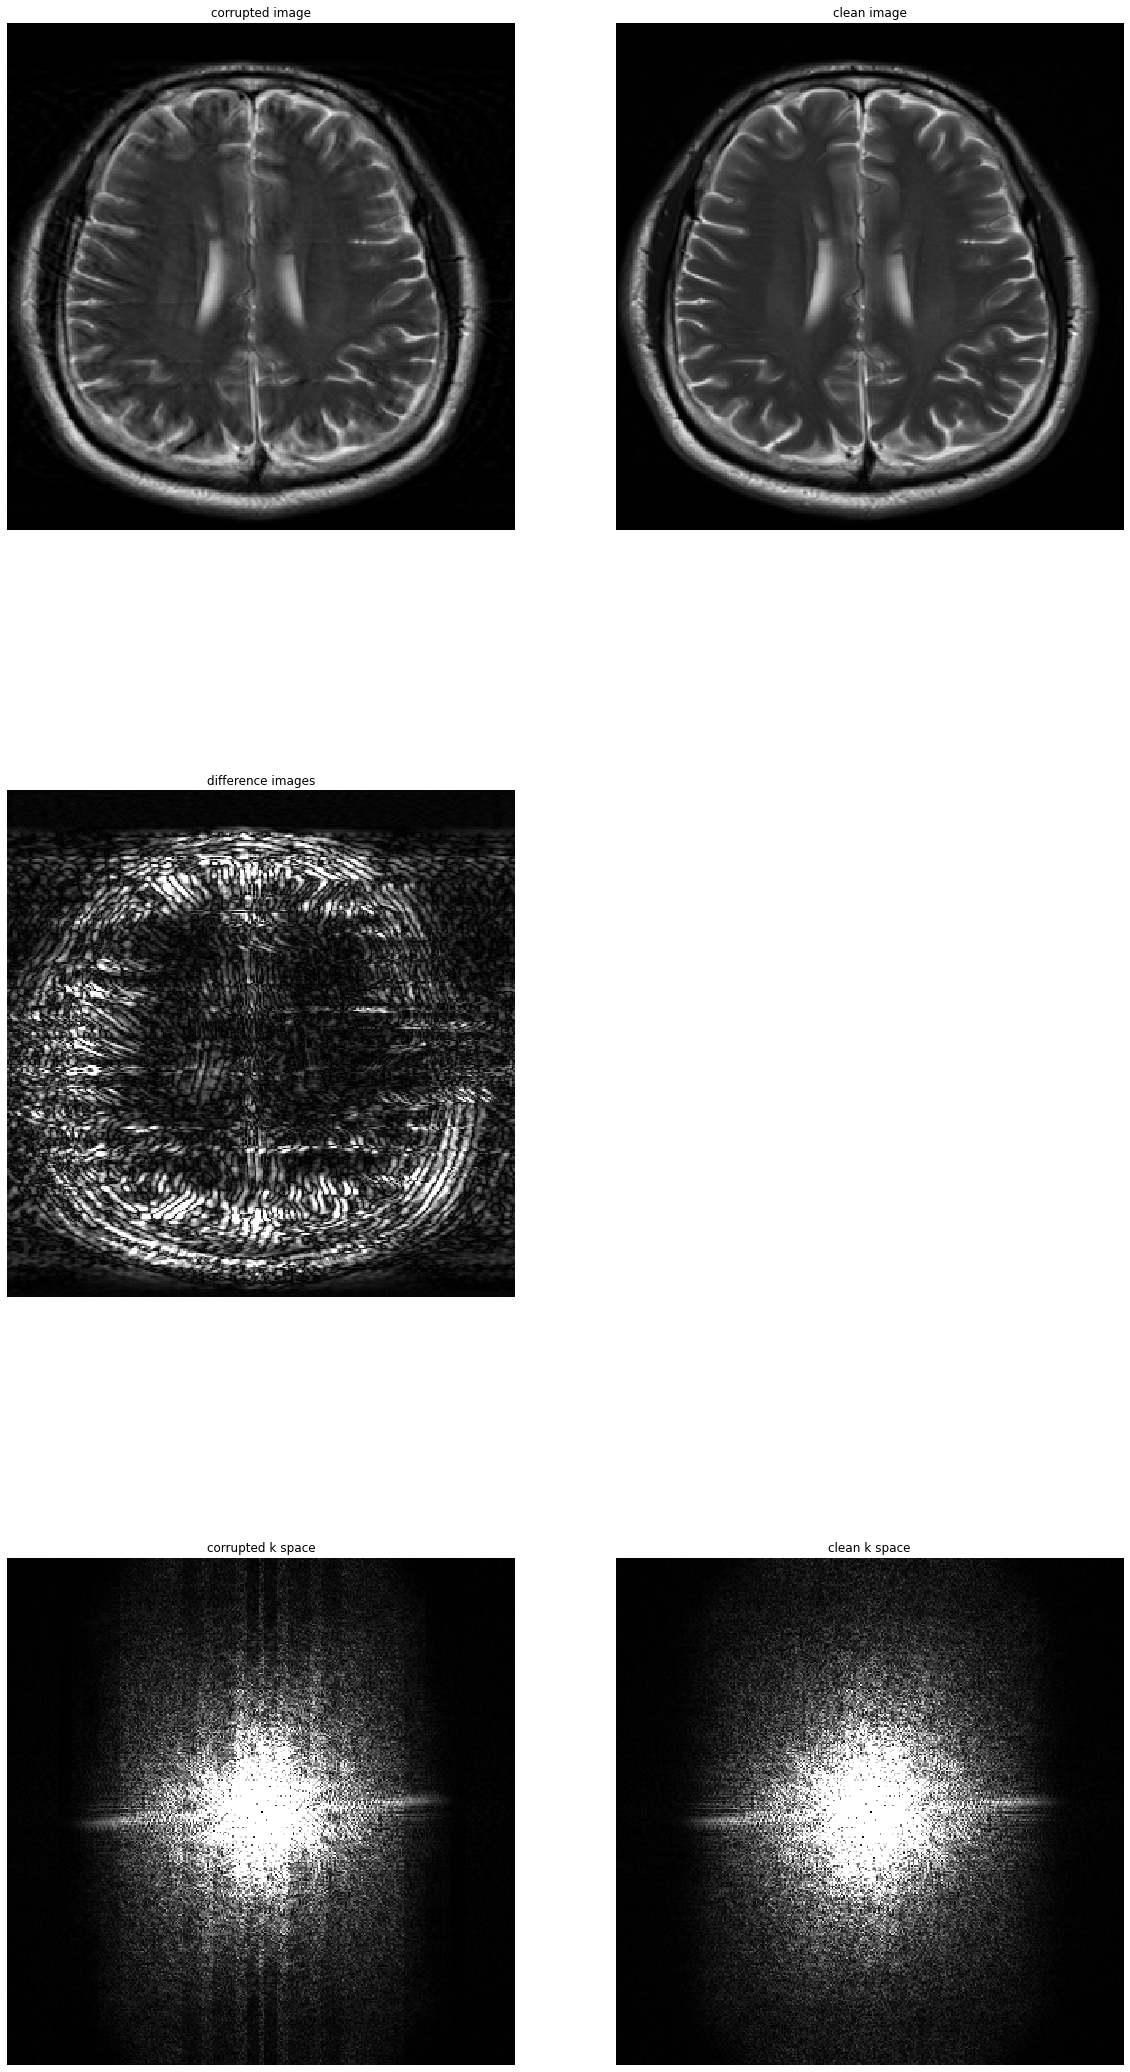

In [3]:
# plotting

n_movements = np.random.randint(1, 10)
ang_std = 1
trans_std = 1
pe_direction = random.choice(["LR", "AP"])
kspace = rigid_motion(image, pe_direction, n_movements, ang_std, trans_std)
img = transform_kspace_to_image(kspace)
img = (img - np.mean(img)) / np.std(img)

hr = image
lr = img

k_lr = np.abs(transform_image_to_kspace(lr))
k_hr = np.abs(transform_image_to_kspace(hr))

k_lr = k_lr / np.max(np.abs(k_lr))
k_hr = k_hr / np.max(np.abs(k_hr))

lr = (lr - np.mean(lr)) / np.std(lr)
hr = (hr - np.mean(hr)) / np.std(hr)

vmx = np.max(hr)
vmn = np.min(hr)
dmx = 0.5
kmx = 0.01

fig = plt.figure(figsize=(20, 40))
ax = fig.add_subplot(3, 2, 1)
ax.imshow(lr, interpolation='none', cmap='gist_gray', vmin=vmn, vmax=vmx)
ax.set_title("corrupted image")
ax.axis('off')
ax = fig.add_subplot(3, 2, 2)
ax.imshow(hr, interpolation='none', cmap='gist_gray', vmin=vmn, vmax=vmx)
ax.set_title("clean image")
ax.axis('off')
ax = fig.add_subplot(3, 2, 3)
ax.imshow(np.abs(lr - hr), interpolation='none', cmap='gist_gray', vmin=0, vmax=dmx)
ax.set_title("difference images")
ax.axis('off')
ax = fig.add_subplot(3, 2, 5)
ax.imshow(k_lr, interpolation='none', cmap='gist_gray', vmin=0, vmax=kmx)
ax.set_title("corrupted k space")
ax.axis('off')
ax = fig.add_subplot(3, 2, 6)
ax.imshow(k_hr, interpolation='none', cmap='gist_gray', vmin=0, vmax=kmx)
ax.set_title("clean k space")
ax.axis('off')

In [4]:
print(np.min(image), np.mean(image), np.std(image), np.max(image))
print(np.min(img), np.mean(img), np.std(img), np.max(img))

-1.0081959379811776 0.0 0.9999999999999998 4.5807967981017566
-1.4535587442555942 7.105427357601002e-17 1.0 4.708542045486636


In [5]:
# the artefacts should be well-balanced in terms of MSE

import os
from sklearn.metrics import mean_squared_error

images_path_list = []
main_path = r'C:\Users\simon\anaconda3\envs\drs\drs\Data\fastMRI_brain_DICOM'
folders = os.listdir(main_path)
for folder in folders:
    folder_path = main_path + '/' + folder
    images = os.listdir(folder_path)
    for image in images:
        image_path = folder_path + '/' + image
        images_path_list.append(image_path)

error_motion_image_total = []

for image_path in images_path_list:
    
    data = pydicom.dcmread(image_path)
    image = data.pixel_array   
    if (np.shape(image) != (320, 320)):
        image = cv2.resize(image, (320, 320))  
    image = (image - np.mean(image)) / np.std(image)
    
    for i in range(10):
        #pe_direction = random.choice(["horizontal", "vertical"])
        #img_motion = rigid_motion(image, 1, 2.5, 2.5, pe_direction)
        n_movements = np.random.randint(1, 10)
        kspace_motion = rigid_motion(image, random.choice(["LR", "AP"]), n_movements, 1.1, 0.6)
        img = transform_kspace_to_image(kspace_motion)
        img_motion = (img - np.mean(img)) / np.std(img)
        
        error_motion_image = mean_squared_error(image, img_motion)
        error_motion_image_total.append(error_motion_image)

print(np.mean(error_motion_image_total), np.std(error_motion_image_total))

0.04143645359715444 0.056223810543171784


In [6]:
# 0.03429101401523494 0.05375213851001139